## Load Libraries

In [1]:
import pandas as pd  #for manipulating data
import sklearn  #for building models
from sklearn.model_selection import train_test_split  #for creating a hold-out sample
import sklearn.ensemble  #for building models
import numpy as np  #for manipulating data

In [2]:
# import lime  #LIME package
# import lime.lime_tabular  #the type of LIIME analysis we’ll do

ModuleNotFoundError: No module named 'lime'

In [3]:
import shap  #SHAP package
import xgboost as xgb  #for building models
import matplotlib  #visualizing output (important when explaining models)
import matplotlib.pyplot as plt  #visualizing output
from mpl_toolkits.mplot3d import axes3d, Axes3D  #visualizing output 
import seaborn as sns  #visualizing output 
import graphviz  #for visualizing the XGBoost tree
import plotly  #visualizing output 
import plotly.plotly as py  #visualizing output 
from plotly import tools  #visualizing output 
import time  #some of the routines take a while, so we monitor the time
import os  #needed to use Environment Variables in Domino
%matplotlib inline  

/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:47: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


## Load and Explore Boston Housing Data

In [4]:
X,y = shap.datasets.boston()
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#### Housing Values in Suburbs of Boston  
**crim**: per capita crime rate by town.  
**zn**: proportion of residential land zoned for lots over 25,000 sq.ft.  
**indus**: proportion of non-retail business acres per town.  
**chas**: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).  
**nox**: nitrogen oxides concentration (parts per 10 million).  
**rm**: average number of rooms per dwelling.  
**age**: proportion of owner-occupied units built prior to 1940.  
**dis**: weighted mean of distances to five Boston employment centres.  
**rad**: index of accessibility to radial highways.  
**tax**: full-value property-tax rate per \$10,000.  
**ptratio**: pupil-teacher ratio by town.  
**b**: 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town.  
**lstat**: lower status of the population (percent).  
**medv**: target variable, median value of owner-occupied homes in \$1000s.  

Source
Harrison, D. and Rubinfeld, D.L. (1978) Hedonic prices and the demand for clean air. J. Environ. Economics and Management 5, 81–102.

Belsley D.A., Kuh, E. and Welsch, R.E. (1980) Regression Diagnostics. Identifying Influential Data and Sources of Collinearity. New York: Wiley.

In [5]:
# put into a df for exploration
y_df = pd.DataFrame(y)
y_df.columns=["MEDV"]
housing = X.join(y_df)
housing.head()

CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   

   PTRATIO       B  LSTAT  MEDV  
0     15.3  396.90   4.98  24.0  
1     17.8  396.90   9.14  21.6  
2     17.8  392.83   4.03  34.7  
3     18.7  394.63   2.94  33.4  
4     18.7  396.90   5.33  36.2

Data Quality Report

In [6]:
# input a dataframe
# returns a dataframe with helpful statistics on the dataframe and its columns

def dqr(d):
    #data types
    dqr_data_types = pd.DataFrame(d.dtypes, columns=['Data Type'])

    #percent missing
    dqr_percent_missing = pd.DataFrame(100*(d.isnull().sum()/len(d)).round(3), columns=['% Missing'])

    #unique values
    dqr_unique_values = pd.DataFrame(columns=['Unique Values'])
    for c in d:
        dqr_unique_values.loc[c]=d[c].nunique()
        
    #mode
    dqr_mode = pd.DataFrame(d.mode().loc[0])
    dqr_mode.rename(columns={ dqr_mode.columns[0]: "Mode" }, inplace=True)
    
    #count mode
    dqr_count_mode = pd.DataFrame(columns=['Count Mode'])
    for c in d:
        dqr_count_mode.loc[c]=d[c][d[c] == dqr_mode.loc[[c]].iloc[0]['Mode']].count()  

    #% mode
    dqr_percent_mode = pd.DataFrame(100*(dqr_count_mode['Count Mode'].values/len(d)), \
        index=dqr_count_mode.index, columns=['% Mode'])
            
    #distribution stats    
    i=1
    for c in d:
        if i==1:
            dqr_stats = pd.DataFrame(d[c].describe())
        if i>1:
            dqr_stats = dqr_stats.join(pd.DataFrame(d[c].describe()))
        i=i+1
    dqr_stats=dqr_stats.transpose().drop('count', axis=1)

    print("# of records: ", len(d))
    print("# of columns: ", len(d.columns))
    
    # don't include count mode
    # .join(dqr_count_mode[['Count Mode']].astype(int))
    
    return dqr_data_types.join(dqr_unique_values[['Unique Values']].astype(int)). \
        join(dqr_percent_missing).join(dqr_mode).join(dqr_percent_mode).join(dqr_stats)

In [7]:
dqr(housing)

# of records:  506
# of columns:  14


Data Type  Unique Values  % Missing       Mode    % Mode        mean  \
CRIM      float64            504        0.0    0.01501  0.395257    3.613524   
ZN        float64             26        0.0    0.00000   73.5178   11.363636   
INDUS     float64             76        0.0   18.10000    26.087   11.136779   
CHAS      float64              2        0.0    0.00000    93.083    0.069170   
NOX       float64             81        0.0    0.53800   4.54545    0.554695   
RM        float64            446        0.0    5.71300  0.592885    6.284634   
AGE       float64            356        0.0  100.00000   8.49802   68.574901   
DIS       float64            412        0.0    3.49520  0.988142    3.795043   
RAD       float64              9        0.0   24.00000    26.087    9.549407   
TAX       float64             66        0.0  666.00000    26.087  408.237154   
PTRATIO   float64             46        0.0   20.20000    27.668   18.455534   
B         float64            357        0.0  396.90000    23.913  356.674032   
LSTAT     float64            455        0.0    6.36000  0.592885   12.653063   
MEDV      float64            229        0.0   50.00000   3.16206   22.532806   

                std        min         25%        50%         75%       max  
CRIM       8.601545    0.00632    0.082045    0.25651    3.677083   88.9762  
ZN        23.322453    0.00000    0.000000    0.00000   12.500000  100.0000  
INDUS      6.860353    0.46000    5.190000    9.69000   18.100000   27.7400  
CHAS       0.253994    0.00000    0.000000    0.00000    0.000000    1.0000  
NOX        0.115878    0.38500    0.449000    0.53800    0.624000    0.8710  
RM         0.702617    3.56100    5.885500    6.20850    6.623500    8.7800  
AGE       28.148861    2.90000   45.025000   77.50000   94.075000  100.0000  
DIS        2.105710    1.12960    2.100175    3.20745    5.188425   12.1265  
RAD        8.707259    1.00000    4.000000    5.00000   24.000000   24.0000  
TAX      168.537116  187.00000  279.000000  330.00000  666.000000  711.0000  
PTRATIO    2.164946   12.60000   17.400000   19.05000   20.200000   22.0000  
B         91.294864    0.32000  375.377500  391.44000  396.225000  396.9000  
LSTAT      7.141062    1.73000    6.950000   11.36000   16.955000   37.9700  
MEDV       9.197104    5.00000   17.025000   21.20000   25.000000   50.0000

## Build the model

XGBoost

In [8]:
xgb_model = xgb.train({'objective':'reg:linear'}, xgb.DMatrix(X_train, label=y_train))

GBT from scikit-learn

In [9]:
sk_xgb = sklearn.ensemble.GradientBoostingRegressor()
sk_xgb.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

Random Forest

In [10]:
rf = sklearn.ensemble.RandomForestRegressor()
rf.fit(X_train, y_train)

/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

K Nearest Neighbor

In [11]:
knn = sklearn.neighbors.KNeighborsRegressor()
knn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform')

## Create the SHAP Explainers

SHAP has the following explainers: deep, gradient, kernel, linear, tree, sampling

Tree on XGBoost

In [12]:
explainerXGB = shap.TreeExplainer(xgb_model)
shap_values_XGB_test = explainerXGB.shap_values(X_test)
shap_values_XGB_train = explainerXGB.shap_values(X_train)

Tree on Scikit GBT

In [13]:
explainerSKGBT = shap.TreeExplainer(sk_xgb)
shap_values_SKGBT_test = explainerSKGBT.shap_values(X_test)
shap_values_SKGBT_train = explainerSKGBT.shap_values(X_train)

Tree on Random Forest

In [14]:
explainerRF = shap.TreeExplainer(rf)
shap_values_RF_test = explainerRF.shap_values(X_test)
shap_values_RF_train = explainerRF.shap_values(X_train)

Must use Kernel method on KNN

Summarizing the data with k-Means is a way to speed up the processing

In [13]:
"""
Rather than use the whole training set to estimate expected values, we summarize with
a set of weighted kmeans, each weighted by the number of points they represent.
Running without the kmeans took 1 hr 6 mins 7 sec. 
Running with the kmeans took 2 min 47 sec.
Boston Housing is a very small dataset.
Running SHAP on models that require Kernel method and have a good amount of data becomes prohibitive. 
"""
X_train_summary = shap.kmeans(X_train, 10)

In [14]:
# using kmeans
t0 = time.time()
explainerKNN = shap.KernelExplainer(knn.predict, X_train_summary)
shap_values_KNN_test = explainerKNN.shap_values(X_test)
shap_values_KNN_train = explainerKNN.shap_values(X_train)
t1 = time.time()
timeit=t1-t0
timeit

100%|██████████| 404/404 [02:31<00:00,  2.67it/s]


190.0371072292328

In [15]:
# without kmeans
# a test run took 3967.6232330799103 seconds
"""
t0 = time.time()
explainerKNN = shap.KernelExplainer(knn.predict, X_train)
shap_values_KNN_test = explainerKNN.shap_values(X_test)
shap_values_KNN_train = explainerKNN.shap_values(X_train)
t1 = time.time()
timeit=t1-t0
timeit 
"""

'\nt0 = time.time()\nexplainerKNN = shap.KernelExplainer(knn.predict, X_train)\nshap_values_KNN_test = explainerKNN.shap_values(X_test)\nshap_values_KNN_train = explainerKNN.shap_values(X_train)\nt1 = time.time()\ntimeit=t1-t0\ntimeit \n'

#### Get the SHAP values into dataframes so we can use them later on

In [16]:
# XGBoost
df_shap_XGB_test = pd.DataFrame(shap_values_XGB_test, columns=X_test.columns.values)
df_shap_XGB_train = pd.DataFrame(shap_values_XGB_train, columns=X_train.columns.values)
# Scikit GBT
df_shap_SKGBT_test = pd.DataFrame(shap_values_SKGBT_test, columns=X_test.columns.values)
df_shap_SKGBT_train = pd.DataFrame(shap_values_SKGBT_train, columns=X_train.columns.values)
# Random Forest
df_shap_RF_test = pd.DataFrame(shap_values_RF_test, columns=X_test.columns.values)
df_shap_RF_train = pd.DataFrame(shap_values_RF_train, columns=X_train.columns.values)
# KNN
# df_shap_KNN_test = pd.DataFrame(shap_values_KNN_test, columns=X_test.columns.values)
# df_shap_KNN_train = pd.DataFrame(shap_values_KNN_train, columns=X_train.columns.values)

## Create the LIME Explainer

In [17]:
# if a feature has 10 or less unique values then treat it as categorical
categorical_features = np.argwhere(np.array([len(set(X_train.values[:,x])) 
                                             for x in range(X_train.values.shape[1])]) <= 10).flatten()

In [18]:
# LIME has one explainer for all models
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, 
                                                   feature_names=X_train.columns.values.tolist(), 
                                                   class_names=['price'], 
                                                   categorical_features=categorical_features, 
                                                   verbose=True, 
                                                   mode='regression')

## Explaining an Instance (local interpretability)

Pick an instance to explain

In [19]:
j = np.random.randint(0, X_test.shape[0])

In [21]:
# optional, set j manually
j = 1

In [23]:
# initialize js
shap.initjs()

### XGBoost

#### SHAP

In [24]:
explainerXGB.expected_value

21.834846

In [25]:
shap_values_XGB_test[j]

array([ 1.3335296 ,  0.01048494, -0.13784805,  0.        ,  0.16124053,
       -0.05973409,  0.13933936, -0.2062886 , -0.04739339, -0.14363645,
       -0.4394854 ,  0.09824811,  2.7690763 ], dtype=float32)

In [26]:
X_test.iloc[[j]]

CRIM   ZN  INDUS  CHAS    NOX     RM    AGE     DIS   RAD    TAX  \
371  9.2323  0.0   18.1   0.0  0.631  6.216  100.0  1.1691  24.0  666.0   

     PTRATIO       B  LSTAT  
371     20.2  366.15   9.53

In [27]:
shap.force_plot(explainerXGB.expected_value, shap_values_XGB_test[j], X_test.iloc[[j]])



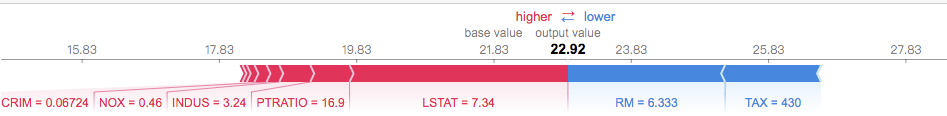

#### 如何理解shap图？
红柱条代表shap值为正，即边际贡献为正，  
蓝柱条代表shap值为负，即边际贡献为负，  
柱条的宽度代表shap值大小  
22.92 代表目标值  
LSTAT = 7.34 代表该样本中特征的值（注意不是shap值）

#### LIME

Out-of-the-box LIME cannot handle the requirement of XGBoost to use xgb.DMatrix() on the input data

In [23]:
# the predict function input doesn't jive wtih LIME
xgb_model.predict(xgb.DMatrix(X_test.iloc[[j]]))

array([ 23.02812386], dtype=float32)

In [26]:
# this will throw an error
expXGB = explainer.explain_instance(X_test.values[j], xgb_model.predict, num_features=5)
expXGB.show_in_notebook(show_table=True)

AttributeError: 'numpy.ndarray' object has no attribute 'feature_names'

### Scikit-learn GBT

#### SHAP

In [24]:
shap.force_plot(explainerSKGBT.expected_value, shap_values_SKGBT_test[j], X_test.iloc[[j]])

#### LIME

In [25]:
expSKGBT = explainer.explain_instance(X_test.values[j], sk_xgb.predict, num_features=5)
expSKGBT.show_in_notebook(show_table=True)

Intercept 22.9447425102
Prediction_local [ 24.61004276]
Right: 25.029662837


### Random Forest

#### SHAP

In [26]:
shap.force_plot(explainerRF.expected_value, shap_values_RF_test[j], X_test.iloc[[j]])

#### LIME

In [27]:
exp = explainer.explain_instance(X_test.values[j], rf.predict, num_features=5)
exp.show_in_notebook(show_table=True)

Intercept 23.527734324
Prediction_local [ 25.11970367]
Right: 24.38


### KNN

#### SHAP

In [28]:
shap.force_plot(explainerKNN.expected_value, shap_values_KNN_test[j], X_test.iloc[[j]])

#### LIME

In [29]:
exp = explainer.explain_instance(X_test.values[j], knn.predict, num_features=5)
exp.show_in_notebook(show_table=True)

Intercept 25.212409696
Prediction_local [ 17.94694087]
Right: 20.76


## Explaining the Global Model

#### Using the XGBoost Model as an example of performing global explanations

### Visualize one of the Trees

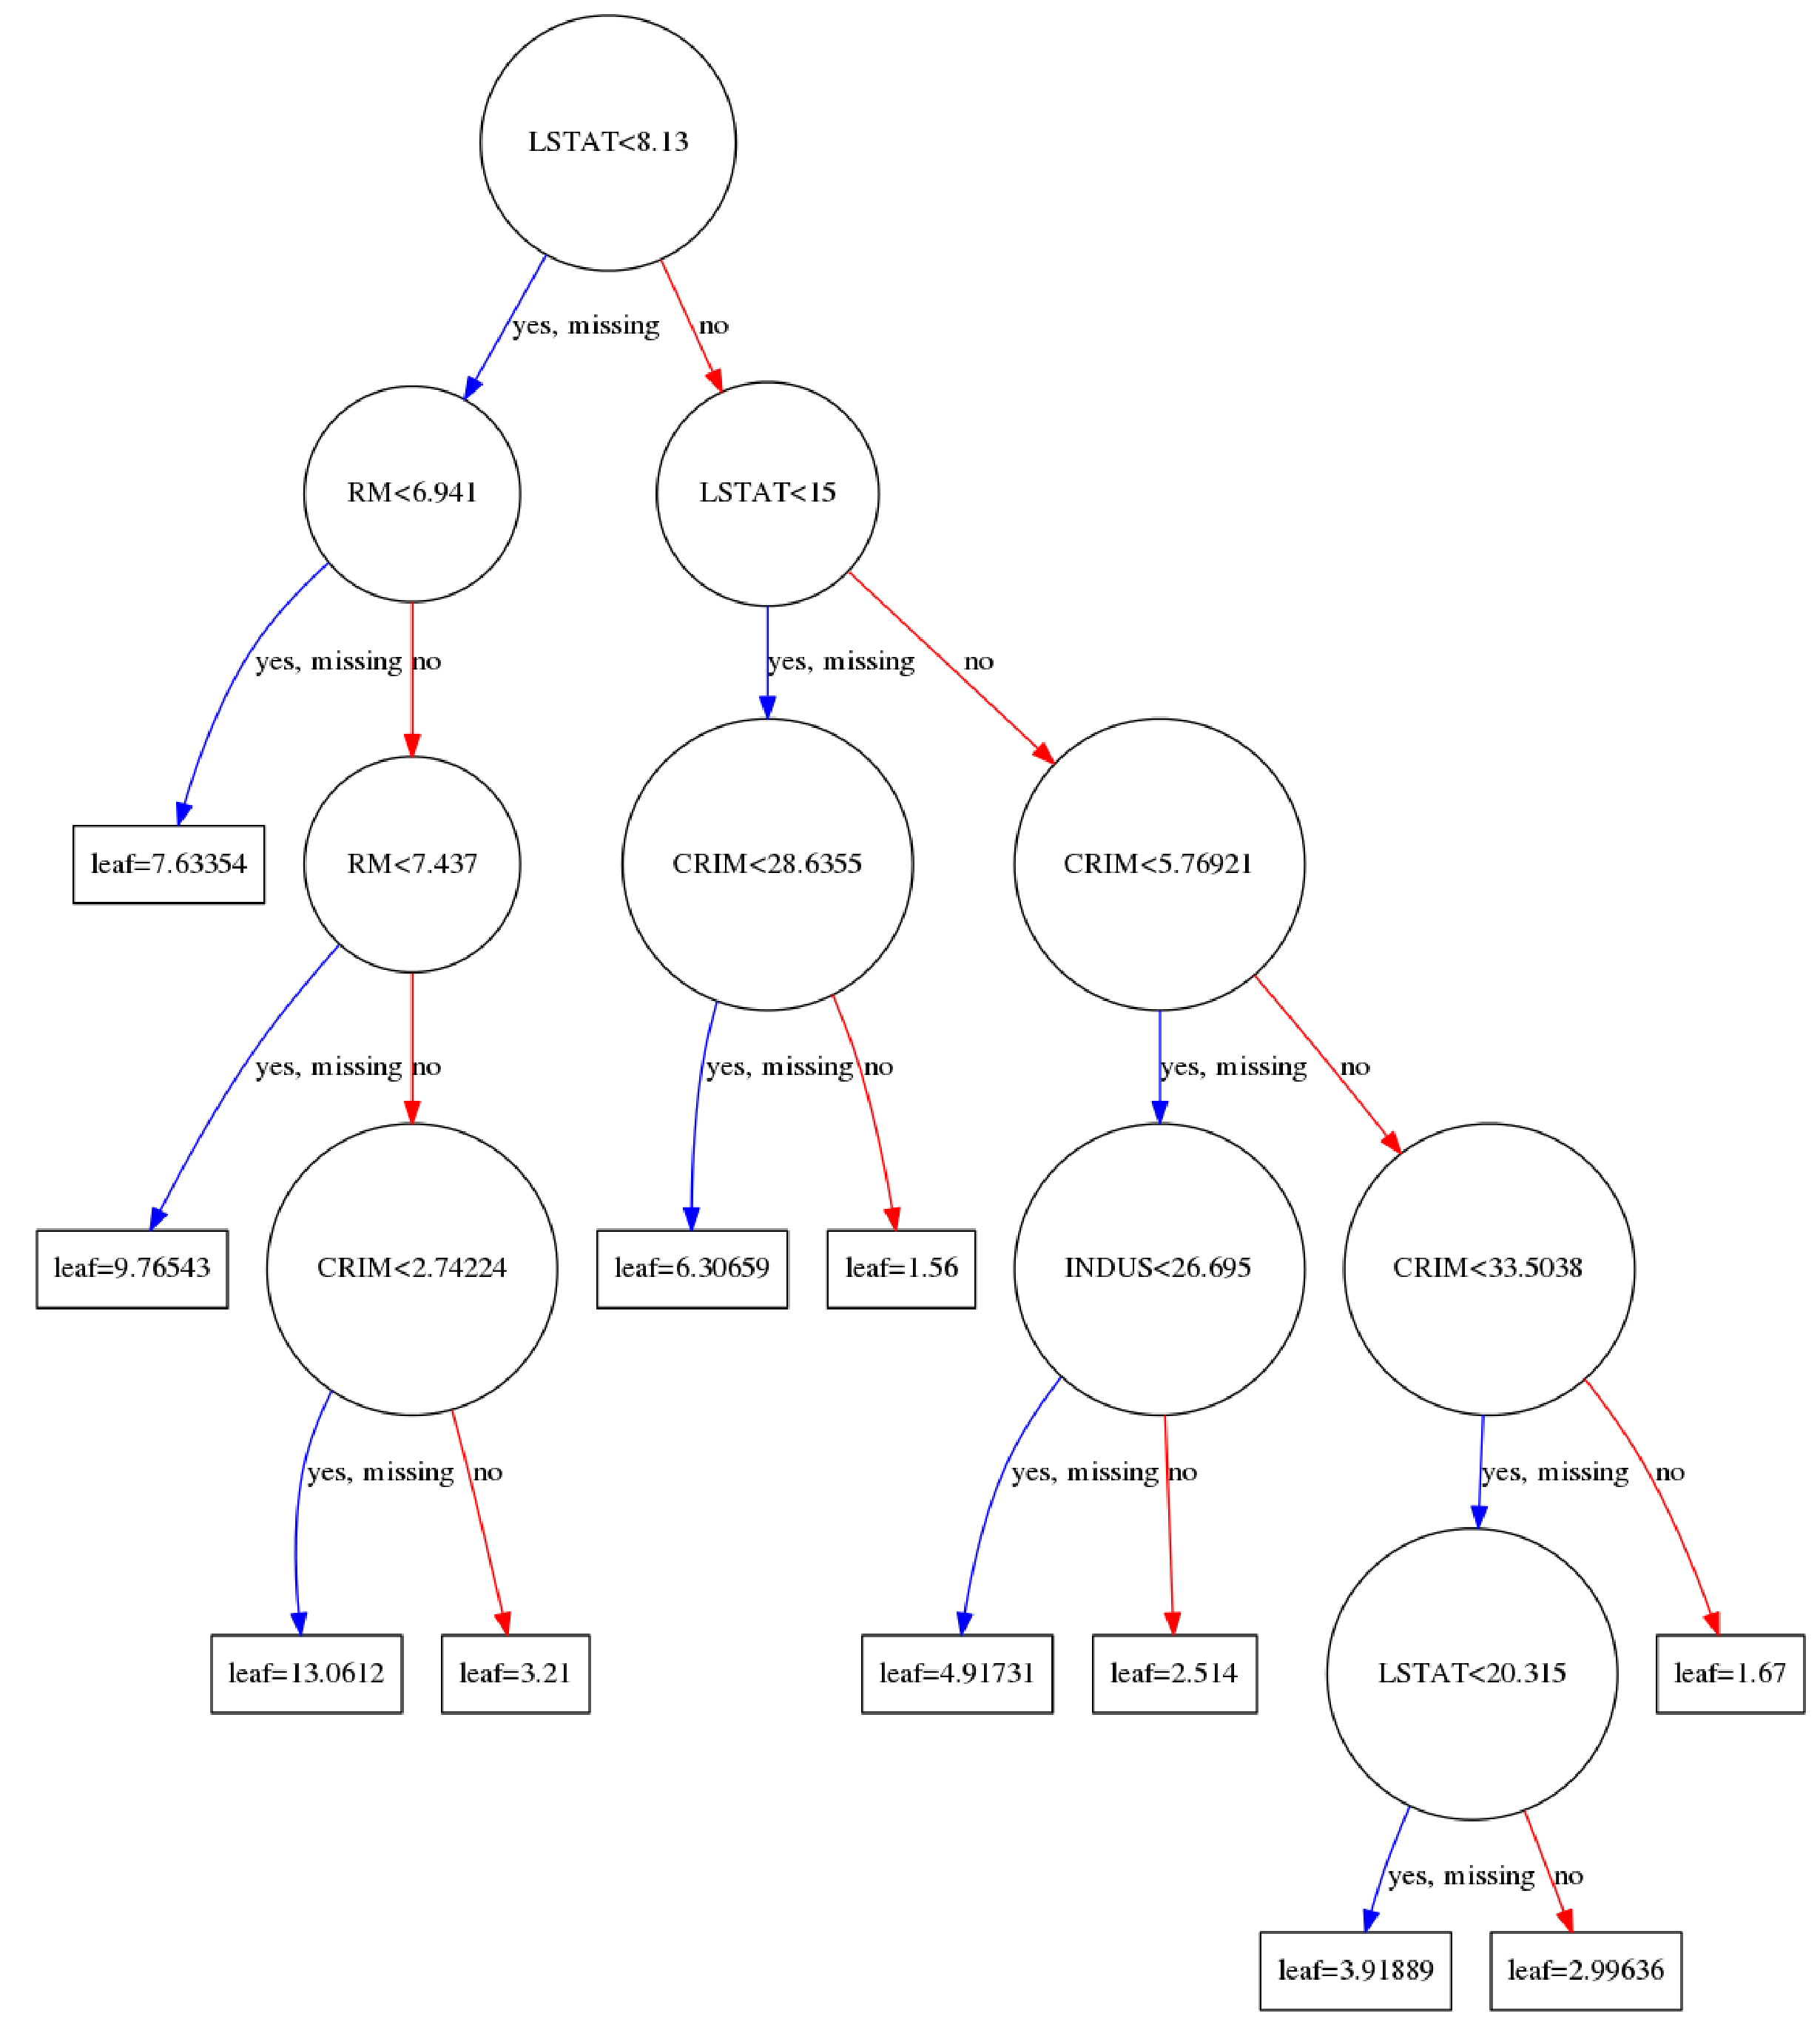

In [30]:
import graphviz
xgb.plot_tree(xgb_model, num_trees=0)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(75, 50)

### Prediction Surface Plot

Define the data to plot

In [31]:
x = X_train['LSTAT']
y = X_train['RM']
z = X_train['CRIM']
c = y_train
p = xgb_model.predict(xgb.DMatrix(X_train))
error = np.abs(c-p)

# convert to 2d matrices - needed when coloring by a 4th variable
X, Y = np.meshgrid(x, y)
Z = np.outer(z.T, z)
C = np.outer(c.T, c)
P = np.outer(p.T, p)
Error = np.outer(error.T, error)

#33% sample for matplot lib as it is so slow
np.random.seed(1)
mask = (np.random.randint(0,3,len(x))==1)
x_samp=x[mask]
y_samp=y[mask]
z_samp=z[mask]
c_samp=c[mask]
p_samp=p[mask]

# convert to 2d matrices - needed when coloring by a 4th variable
X_samp, Y_samp = np.meshgrid(x_samp, y_samp)
Z_samp = np.outer(z_samp.T, z_samp)
C_samp = np.outer(c_samp.T, c_samp)
P_samp = np.outer(p_samp.T, p_samp)

#### Plot using matplotlib

Color by the predicted value

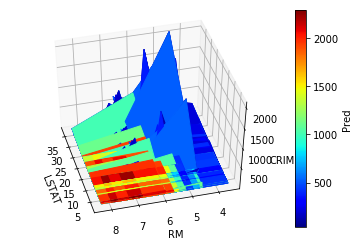

In [32]:
color_dimension = P_samp # change to desired fourth dimension
minn, maxx = color_dimension.min(), color_dimension.max()
m = plt.cm.ScalarMappable(cmap='jet')
m.set_array([])
fcolors = m.to_rgba(color_dimension)

fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X_samp,Y_samp,Z_samp, rstride=1, cstride=1, 
                       facecolors=fcolors, vmin=minn, vmax=maxx, shade=False)
ax.set_xlabel('LSTAT')
ax.set_ylabel('RM')
ax.set_zlabel('CRIM')
plt.colorbar(m).set_label("Pred")
ax.view_init(45, 165)
plt.show()

#### Plot using plotly

In [33]:
import plotly
import plotly.plotly as py
from plotly import tools
# Env Vars can be created in Domino from the project Settings page
# The run  will need to be restarted if this is your first time 
plotly.tools.set_credentials_file(username=os.environ['PlotlyUN'], api_key=os.environ['PlotlyKEY'])

Color by the predicted value

In [34]:
df = {'x': X, 'y': Y, 'z': Z, 'type': 'surface', 'surfacecolor': P}
fig = tools.make_subplots(rows=1, cols=1, specs=[[{'is_3d': True}]])
fig.append_trace(df, 1, 1)
py.iplot(fig)

This is the format of your plot grid:
[ (1,1) scene1 ]



Color by the prediction error

In [35]:
df = {'x': X, 'y': Y, 'z': Z, 'type': 'surface', 'surfacecolor': Error}
fig = tools.make_subplots(rows=1, cols=1, specs=[[{'is_3d': True}]])
fig.append_trace(df, 1, 1)
py.iplot(fig)

This is the format of your plot grid:
[ (1,1) scene1 ]



### Variable Importance

#### Importance plot via traditional methods

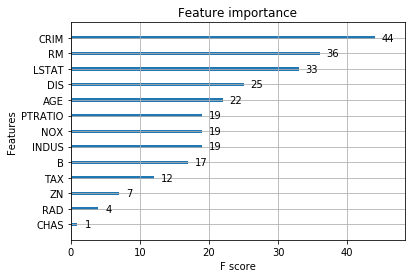

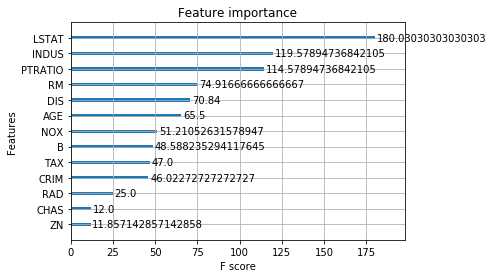

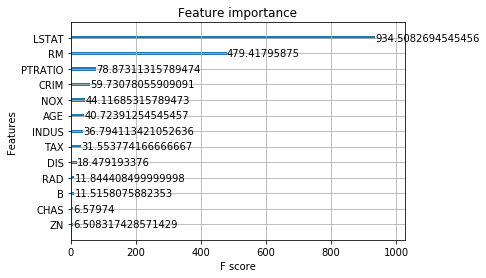

In [36]:
xgb.plot_importance(xgb_model, importance_type = 'weight')
xgb.plot_importance(xgb_model, importance_type = 'cover')
xgb.plot_importance(xgb_model, importance_type = 'gain')

#### Importance plot via SHAP values

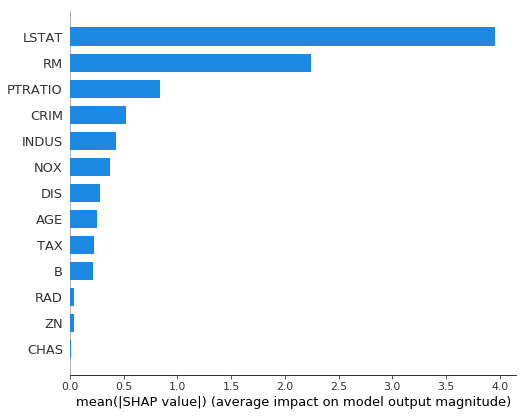

In [37]:
shap.summary_plot(shap_values_XGB_train, X_train, plot_type="bar")

#### Similar to variable importance, this shows the SHAP values for every instance from the training dataset

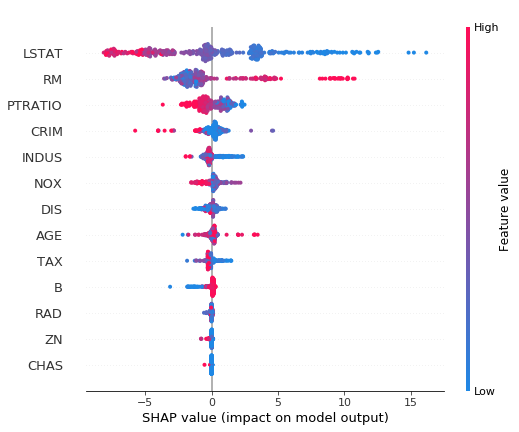

In [38]:
shap.summary_plot(shap_values_XGB_train, X_train)

#### Variable Influence or Dependency Plots

Default SHAP dependency plot

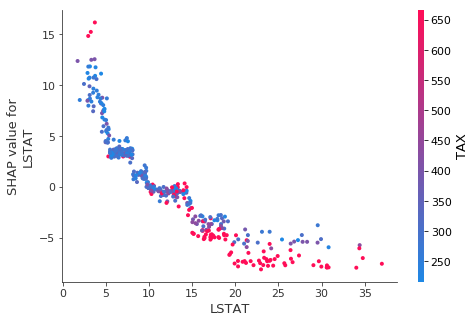

In [39]:
shp_plt = shap.dependence_plot("LSTAT", shap_values_XGB_train, X_train)

The following modifies the default graph a bit to (1) highlight the jth instance with a black dot and (2) pick the color by variable ourselves

In [40]:
# inputs = column of interest as string, column for coloring as string, df of our data, SHAP df, 
#          x postion of the black dot, y position of the black dot

def dep_plt(col, color_by, base_actual_df, base_shap_df, overlay_x, overlay_y):
    cmap=sns.diverging_palette(260, 10, sep=1, as_cmap=True) #seaborn pallete
    f, ax = plt.subplots()
    points = ax.scatter(base_actual_df[col], base_shap_df[col], c=base_actual_df[color_by], s=20, cmap=cmap)
    f.colorbar(points).set_label(color_by)
    ax.scatter(overlay_x, overlay_y, color='black', s=50)
    plt.xlabel(col)
    plt.ylabel("SHAP value for " + col)
    plt.show()

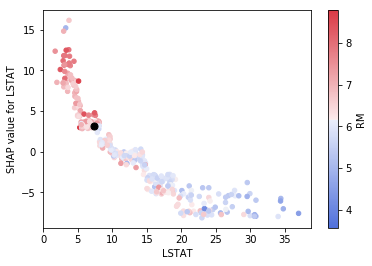

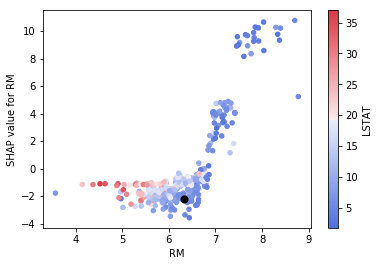

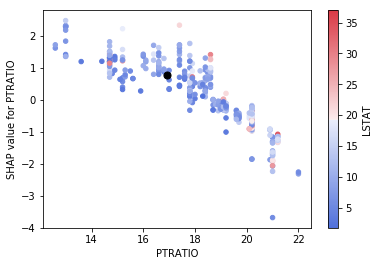

In [41]:
# get list of model inputs in order of SHAP importance
imp_cols = df_shap_XGB_train.abs().mean().sort_values(ascending=False).index.tolist()

# loop through this list to show top 3 dependency plots
for i in range(0, len(imp_cols)):
    #plot the top var and color by the 2nd var
    if i == 0 : 
        dep_plt(imp_cols[i], 
                imp_cols[i+1], 
                X_train, 
                df_shap_XGB_train,
                X_test.iloc[j,:][imp_cols[i]], 
                df_shap_XGB_test.iloc[j,:][imp_cols[i]])
    #plot the 2nd and 3rd vars and color by the top var
    if (i > 0) and (i < 3) : 
        dep_plt(imp_cols[i], 
                imp_cols[0], 
                X_train, 
                df_shap_XGB_train,
                X_test.iloc[j,:][imp_cols[i]], 
                df_shap_XGB_test.iloc[j,:][imp_cols[i]])

### Embaed an image of SHAP from a network run on an env + hdw combo supporting keras

![image](results/shap_vgg.png)